In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
import math

import datetime

import seaborn as sns
sns.set()

In [2]:
stock = 'BRK-B'
method = 'ag'

df = pd.read_csv(f'data/{stock.lower()}_{method}.csv') #! remember to remove usecols
df.date = pd.to_datetime(df.date)

df['last_close'] = df['close'].shift(1)
df = df.iloc[1:]

df

,date,close,min,max,forecast,lower,upper,last_close
1,2020-05-21,183.429993,183.289993,186.669998,185.751586,180.991116,190.637267,185.660004
2,2020-05-22,183.509995,182.539993,184.460007,183.617777,178.846539,188.516302,183.429993
3,2020-05-26,181.570007,181.100006,186.500000,183.701864,179.211853,188.304369,183.509995
4,2020-05-27,181.809998,176.600006,181.990005,181.831493,177.307486,186.470930,181.570007
5,2020-05-28,181.399994,180.380005,184.149994,182.058582,177.765799,186.455030,181.809998
...,...,...,...,...,...,...,...,...
249,2021-05-17,245.179993,243.520004,246.589996,248.482677,240.139870,257.115325,248.149994
250,2021-05-18,243.080002,242.899994,246.410004,245.620979,237.708299,253.797050,245.179993
251,2021-05-19,243.119995,238.600006,243.229996,243.580506,236.143806,251.251404,243.080002
252,2021-05-20,246.479996,243.860001,247.949997,243.591892,236.721042,250.662169,243.119995


# Plotting

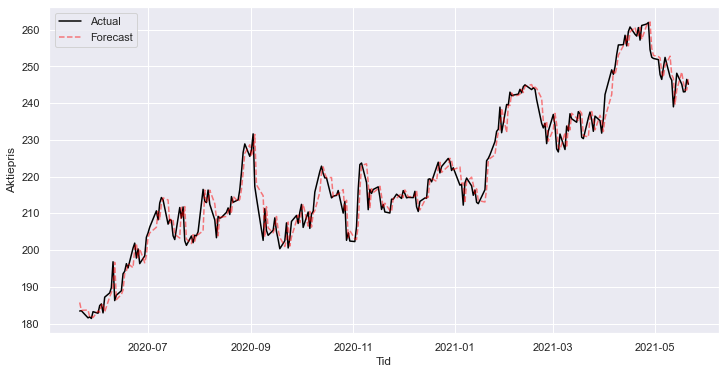

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label="Actual", color="black")
plt.plot(df['date'], df['forecast'], label="Forecast", color="red", alpha=0.5, linestyle="--")
plt.xlabel('Tid')
plt.ylabel('Aktiepris')
plt.legend()

# Trading

## Basic

In [4]:
# df['sentiment'] = df.apply(lambda x: 'buy' if x.forecast > x.last_close else 'sell', axis=1)

def ci_sentiment(row):
    # Selling only allowed when absolutely sure
    sentiment = 'hold'

    if row.forecast > row.last_close:
        sentiment = 'buy'
    elif row.upper < row.last_close:
        sentiment = 'sell'
    
    return sentiment

df['sentiment'] = df.apply(lambda x: ci_sentiment(x), axis=1)

buy     203
hold     50
Name: sentiment, dtype: int64

In [5]:
# Setup
periods = len(df)
BANK_START = 10000
RISK_MAX = 0.25

# Values updated when iterating
stock_count = 0
nr_buys = 0
nr_sells = 0
bank = BANK_START

portfolio_array = [] # to keep track of portfolio value over time
action = []
nr_traded = []

for i, row in df.iterrows():
    portfolio = stock_count * row.last_close
    total_value = portfolio + bank
    portfolio_array.append(total_value)

    max_to_trade = math.floor(total_value * RISK_MAX / row.last_close)
    nr_to_buy = max_to_trade if max_to_trade * row.last_close < bank else math.floor(bank / row.last_close)
    nr_to_sell = max_to_trade if max_to_trade < stock_count else stock_count

    if row.sentiment == 'buy' and nr_to_buy > 0:
        bank -= row.last_close * nr_to_buy
        stock_count += nr_to_buy
        nr_buys += nr_to_buy
        action.append('buy')
        nr_traded.append(nr_to_buy)

    elif row.sentiment == 'sell' and nr_to_sell > 0:
        bank += row.last_close * nr_to_sell
        stock_count -= nr_to_sell
        nr_sells += nr_to_sell
        action.append('sell')
        nr_traded.append(nr_to_sell)

    else:
        action.append('hold')
        nr_traded.append(0)

df['action'] = action
df['nr_traded'] = nr_traded
df['total_value'] = portfolio_array

trading_yield = round( ((df.total_value.iloc[-1] / BANK_START) * 100) - 100, 2)
index_yield = round( (df.last_close.iloc[-1]-df.last_close.iloc[0]) / df.last_close.iloc[0] * 100, 2)
print(f'Trading yield: {trading_yield}%')
print(f'Index yield: {index_yield}%')

Trading yield: 34.02%
Index yield: 32.76%


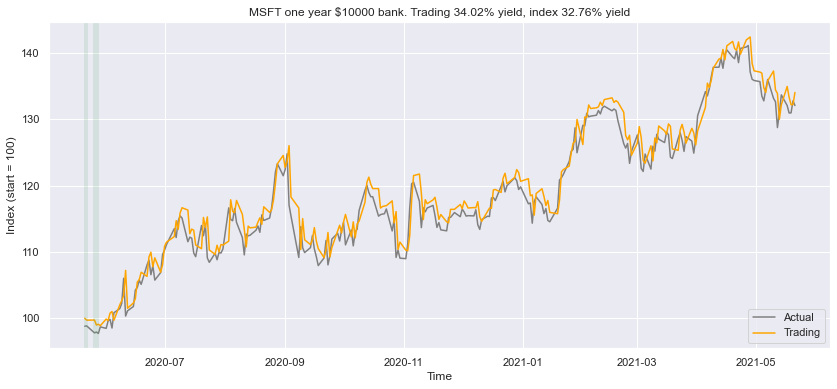

In [6]:
df['yield_index'] = 100*(df['close']/df.last_close.iloc[0] - 1) + 100
df['yield_trade'] = 100*(df['total_value']/BANK_START - 1) + 100

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['yield_index'], label="Actual", color="gray")
plt.plot(df['date'], df['yield_trade'], label="Trading", color="orange")
plt.xlabel('Time')
plt.ylabel('Index (start = 100)')
plt.title(f'{stock} one year ${BANK_START} bank. Trading {trading_yield}% yield, index {index_yield}% yield')
plt.legend()

# plotting vertical lines for but and sell
for i, row in df.iterrows():
    if row.action == 'buy':
        plt.axvline(row.date, color="g", lw=0.3)
    
    if row.action == 'sell':
        plt.axvline(row.date, color="r", lw=0.3)